# Data Cleansing
#### Dahye Kim

Date: 12/10/2020

Environment: Python 3 and Jupyter notebook

Libraries used:
* itertools
    * ``chain`` and ``permutation`` function
* pandas 
    * Read and manipulate data frame
* numpy 
    * Use linear systems to solve linear algebra
* re
    * Extract part of strings 
* haversine 
    * Calculate haversine distance between two locations based on their latitude and longitude
* nltk.sentiment.vader
    * ``SentimentIntensityAnalyzer``
    * Sentiment analysis of customer reviews
* sklearn.linear_model 
    * ``LinearRegression`` 
    * Build multiple regression model for linearly dependent variables 
* matplotlib
    * ``pyplot`` 
    * Plot boxplot, scatter plot, and histogram for visualising distribution of variables

In [ ]:
from __future__ import division # chaining series of iterative lists
from itertools import chain 
from itertools import permutations
import pandas as pd 
import numpy as np 
import re 
from haversine import haversine, Unit
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt 
%matplotlib inline

# Introduction 

This program cleanse the dataset, which contains transactional retail data from an online electronic store located in Melbourne, Australia. The wrangling process include three major steps for targeting different types of data anomalies: 

* Detect and correct syntatctic and semantic errors 
* Remove outliers 
* Impute missing data based on the type of missing values

# Part 1. Detect and Correct Syntatctic and Semantic errors 

Part 1 is divided into two parts - (1) correcting syntactic errors and (2) correcting semantic errors. 
To clean the datasets with anomalies, first I corrected the syntactic errors in the data set. **Syntactic anomalies** include errors tackles the errors of the values or the format of the data types. This includes, lexical, domain format errors and irregularities in non-uniform use of values. **Semantic anomalies**, on the other hand, tackles the comprehensiveness and redundancy of the data set. This includes integrity constraints violations, contradictions of values based on values of other attributes, duplicates or invalid observations. 

Part 1 first starts off with briefly understanding the structure of the data frame, including the numbers of rows and columns, the data types of the values in each column, as well as the column names. Based on this observations, I tried to see which columns could contain what type of errors in their values (syntatctical anomalies), and which attributes could be related to another (semantic anomalies). I also checked if there is any null values within the data frame before starting correcting any potential errors.

Since each row contains only one error of each type of anomaly, I created a list to keep in track of the rows that I corrected. 

To clean the data sets with both syntactic and semantic anomalies, we first need to correct the *syntactic anomalies* since the syntatctic errors are independent of the values of other attributes. Therefore, part 1 begins with detection and correction of syntactical errors in each attribute. 

In [2]:
orders = pd.read_csv('dirty_data.csv')
# read in the data set with asyntactical and semantic anomalies

In [3]:
orders.info()
# no null values detected in any attribute

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       500 non-null    object 
 1   customer_id                    500 non-null    object 
 2   date                           500 non-null    object 
 3   nearest_warehouse              500 non-null    object 
 4   shopping_cart                  500 non-null    object 
 5   order_price                    500 non-null    int64  
 6   delivery_charges               500 non-null    float64
 7   customer_lat                   500 non-null    float64
 8   customer_long                  500 non-null    float64
 9   coupon_discount                500 non-null    int64  
 10  order_total                    500 non-null    float64
 11  season                         500 non-null    object 
 12  is_expedited_delivery          500 non-null    boo

## Syntatical Errors 

In [4]:
syntatical = list()
# the list to record the row index whose errors are corrected
# using a list in case of repeated indexes

### 1. Warehouse Names

The correct name and locations of three warehouses are given in ``warehouse.csv``. Assuming that this file does not contain any error, the names of warehouses within ``nearest_warehouse`` column should be identical to those in ``warehouse.csv`` file.
I first started by detecting anomalies in values within ``nearest_warehouse`` column and check if there is any errors within the values themselves (misspellings, inconsistencies, etc.)  

In [5]:
warehouse = pd.read_csv('warehouses.csv')
warehouseNames = set(warehouse.names)
# read in the 'warehouse.csv' file and retrieve the unique names of the warehouses
warehouseNames
# there are three unique names of the warehouses

{'Bakers', 'Nickolson', 'Thompson'}

In [6]:
pd.unique(orders.nearest_warehouse)
# there are six unique values in orders.nearest_warehouse dataframe 
# three of them are identical to those in 'warehouse.csv'
# inconsistencies in spelling detected

array(['Nickolson', 'Bakers', 'Thompson', 'bakers', 'nickolson',
       'thompson'], dtype=object)

In [7]:
syntatical+=list(orders.index[~orders.nearest_warehouse.isin(warehouseNames)])
# append the row index where the misspelling of warehouse names are detected
orders.loc[syntatical,'nearest_warehouse']

26        bakers
81     nickolson
83        bakers
86     nickolson
98      thompson
116       bakers
142    nickolson
148    nickolson
178    nickolson
199    nickolson
238     thompson
258     thompson
293     thompson
351       bakers
375     thompson
396    nickolson
398       bakers
446     thompson
460       bakers
472       bakers
Name: nearest_warehouse, dtype: object

In [8]:
orders['nearest_warehouse'] = orders['nearest_warehouse'].apply(lambda x: x.capitalize())
# Since the anomalies are the inconsistencies is cases
# I applied 'capitalize()' function to all the rows in 'nearest_warehouse' column with .apply() function

print("The warehouse names in 'nearest_warehouse' columns are:\n", ', '.join(pd.unique(orders['nearest_warehouse'])))
# No more inconsistencies detected in nearest_warehouse column

The warehouse names in 'nearest_warehouse' columns are:
 Nickolson, Bakers, Thompson


### 2. Validating Latitude and Longitude

The warehouse is located in Melbourne, Australia. Legitimate longitude and latitude of any locations within Melbourne area should be similar to $\left(-37.8136^{\circ}, 144.9631^{\circ}\right)$. To check the correctness of the value and the consistency of the format, I followed the following steps: 
1. Double-check the data type of the values in ``customer_lat`` and ``customer_long`` columns
2. Check if the latitude is negative and longitude and positive 
3. Check if the longitude and latitude and close to those of Melbourne or not 

In [9]:
orders[['customer_lat','customer_long']].dtypes

customer_lat     float64
customer_long    float64
dtype: object

In [10]:
list(orders.index[(orders.customer_long+37<0)&(orders.customer_lat-144>0)])==\
list(orders.index[(orders.customer_long<0)|(orders.customer_lat>0)])
# The rows whose latitude is positive and longitude is negative is identical to those whose latitude and longitude 
# is far away from Melbourne 

True

In [11]:
orders[(orders.customer_long<0)|(orders.customer_lat>0)][['customer_lat','customer_long']]
# The customer_lat and customer_long values of these rows are in fact inserted other way round 

,customer_lat,customer_long
46,144.972615,-37.799848
59,144.966146,-37.808890
100,145.010112,-37.800698
134,144.959312,-37.812090
137,144.992497,-37.807224
141,144.947320,-37.808800
156,145.015023,-37.821247
164,144.975366,-37.810743
183,144.949225,-37.804398
202,144.952223,-37.821829


In [12]:
syntatical+=list(orders.index[(orders.customer_long<0)|(orders.customer_lat>0)])
# adding the row index to syntactical to keep on track of the corrected rows

In [13]:
for i in set(orders.index[(orders.customer_long<0)|(orders.customer_lat>0)]):
    orders.loc[i,'customer_lat'], orders.loc[i,'customer_long'] = orders.loc[i,'customer_long'],orders.loc[i,'customer_lat']
# Change the customer_lat and customer_long values around 

In [14]:
if not set(orders.index[(orders.customer_long<0)|(orders.customer_lat>0)])\
and not set(orders.index[(orders.customer_long+37<0)&(orders.customer_lat-144>0)]): 
    print('There is no syntatical errors in latitude and longitude columns.')
# No more errors in these two columns detected

There is no syntatical errors in latitude and longitude columns.


### 3. Validating Season Names

The domain of values for season names is very limited - there should be only four legitimate values available for this column. Therefore, I checked the unique values in the column and see if there is any consistencies or misspellings in the column.

In [15]:
pd.unique(orders.season)
# Similar to the warehouse names, the cases of season is also not consistent. 

array(['Spring', 'Autumn', 'Winter', 'Summer', 'autumn', 'winter',
       'summer', 'spring'], dtype=object)

In [16]:
correctSeasons = pd.unique(orders.season)[:4]
# extract the capitalised season names and assume that the capitalised case is the correct case for the column values
correctSeasons

array(['Spring', 'Autumn', 'Winter', 'Summer'], dtype=object)

In [17]:
syntatical+=list(orders.index[~orders['season'].isin(correctSeasons)])
# add the index of the rows with wrong cases to list syntactical 
# [~orders['season'].isin(correctSeasons)]
# ~ means 'not', similar to '!' in R
# .isin() function checks if the values in a column is in the input parameter array
# If the values in 'season' is not in correctSeasons list, then the index of the matching row is appended to syntactical

orders.season = orders.season.apply(lambda x: x.capitalize())
# Same method as the warehouse name correction, simply capitalise all the value in the entire column for consistency

In [18]:
print("The unique season names in the 'season' column are:\n",', '.join(pd.unique(orders.season)))
# Check again if the values in season column is faulty by calling pd.unique() function

The unique season names in the 'season' column are:
 Spring, Autumn, Winter, Summer


### 4. Correcting Data Type of shopping_cart Column and Validating Unique Product Names

In the meta data, the column ``shopping_cart`` is a list of tuples representing the item and the quantity ordered. Therefore, I checked if the data type of the column ``shopping_cart`` should be an array. With ``dtypes`` attribute above, we the data type is shown as ``object``, which cannot inform us if the value is actually an array or a string. To do so, I used ``apply`` function and called ``isinstance(x, list)`` to all the values in ``shopping_cart`` column, in order to create a Boolean series to check if the values in ``shopping_cart`` columns are list is not. I converted the series then to set - If the set has both ``True`` and ``False``, the column has mixture of list and other data types; if the set has only ``False``, the data type of the values in ``shopping_cart`` column is not a list; otherwise, the values are all lists. 

In [19]:
set(orders['shopping_cart'].apply(lambda x: isinstance(x, list)))
# None of the values in the 'shopping_cart' column is a list

{False}

In [20]:
set(orders['shopping_cart'].apply(lambda x: isinstance(x, str)))
# All values in the 'shopping_cart' column is a string

{True}

In [21]:
orders['shopping_cart'] = \
orders['shopping_cart'].apply(lambda x: list(zip(re.findall(r"\(\'(.+?)\',",x), [int(qty) for qty in re.findall(r"\, ([0-9]{1})\)",x)])))
# converting the data type of values in 'shopping_cart' column into a list of tuples using list() and zip()

# with regex, extracting two elements in each tuple - the product name and the order quantity 
# r"\(\'(.+?)\'," - the raw strings, any characters between '(' and ',' quoted by '' but not greedy
# r"\, ([0-9]{1})\)" - the raw strings, one-digit number between 0 and 9 located in between ', ' and ')' 
# re.findall extracts all the strings matching the regex input, and returns a list composed of all the matching strings 

# zip two lists together into multiple tuples and then put all the tuples into a list 

In [22]:
set(orders['shopping_cart'].apply(lambda x: isinstance(x, list)))
# The shopping_cart is now lists of tuples

{True}

After converting the strings in the ``shopping_cart`` column into lists, we need to validate the product names in each tuple and detect any potential inconsistencies or faulty values.

In [23]:
uniqueItems = set([i[0] for i in list(chain.from_iterable(orders.shopping_cart))])
# with chain.from_iterable() to loop through all the tuples in shopping_cart column 
# the first element in the tuple is the product name 
# use set to filter all the duplicated product name - similar to pd.unique() for extracting unique values in a series

In [24]:
print('The number of unique products sold is:',len(uniqueItems),\
      '\nThe unique products are:\n',',\n'.join(uniqueItems))
# 10 unique products, no inconsistencies or misspellings observed amongst the product names listed.

The number of unique products sold is: 10 
The unique products are:
 iAssist Line,
Thunder line,
Alcon 10,
Olivia x460,
Universe Note,
Candle Inferno,
iStream,
Toshika 750,
Lucent 330S,
pearTV


### 5. Validating Numerical Values with Suitable Domains

For the columns with numerical values, such as ``order_price``, ``order_total``, and ``distance_to_nearest_warehouse``, the value should be positive integers. Since the data set recorded each transaction that has taken place, the values should also not equal to zero. To check if the values in forementioned columns are in the right domain, I ran a ``for``-loop and checked each value in these columns by calling ``.loc[]`` function. 

In [25]:
for i in range(orders.shape[0]): 
    if orders.loc[i, 'order_price']<=0\
    or orders.loc[i, 'order_total']<=0\
    or orders.loc[i, 'distance_to_nearest_warehouse']<0: 
        print(i)
# All values in these three columns are in the correct domain. No syntactic errors detected. 

### 6. Validating Date Format Consistency

According to the meta data, the date should follow 'YYYY-MM-DD' format. To validate the date format, I created a regex as follow: 

``2019-((0[13578]|1[02])-(0[1-9]|[12][0-9]|[3][01]))|(0[469]|11)-(0[1-9]|[12][0-9]|30)|02-(0[1-9]|1[0-9]|2[0-8])``

a string starts with '2019-'followed by different MM-DD combinations, connected by ``|``: 
* ``((0[13578]|1[02])-(0[1-9]|[12][0-9]|[3][01]))``: the months that have 31 days in total and are single-digit should starts with a 0. The months with 31 days should be Jan, Mar, May, Jul, Aug, Oct, and Dec. The single-digit days should also start with 0. The days starting with 0 should be followed by a digit ranging from 0 - 9. The days starting with 1 or 2 should also be followed by a digit ranging from 0 - 9. The days starting with 3 should be either 30 or 31. 

* ``(0[469]|11)-(0[1-9]|[12][0-9]|30)``: the months with 30 days in total - months with single-digit, Apr, Jun, Sep, should start with 0. Or else the month should be Nov. The days with single digit should also start with 0. Additionally, the days starting with 0, 1, or 2 should be followed by a digit ranging from 0 to 9. The days starting with 3 should be only 30. 

* ``02-(0[1-9]|1[0-9]|2[0-8])``: 2019 is a non-leap year, and therefore there are only 28 days in February. February is a single-digit month, denoted as '02'. The single-digit days should also start with 0. The days starting with 0 should be followed by a digit ranging from 0 - 9. The days starting with 1 should also be followed by a single number ranging from 0 - 9. The days starting with 2 should be followed by a digit ranging from 0 to 8. 

The date value that does not match this regex does not 'YYYY-MM-DD' format.

In [26]:
index_inconsistentDate=set()
# create an empty set to record the index of the rows whose date format is inconsistant

for i in range(orders.shape[0]):
# loop through each date value by its index and .loc[] function
    if not re.findall(r'2019-((0[13578]|1[02])-(0[1-9]|[12][0-9]|[3][01]))|(0[469]|11)-(0[1-9]|[12][0-9]|30)|02-(0[1-9]|1[0-9]|2[0-8])', orders.loc[i,'date']):
    # if re.findall() with the regex returns an empty list
        syntatical.append(i)
        # append the row index to syntactical list
        index_inconsistentDate.add(i)
        # add the index to index_inconsistentDate set

orders.loc[index_inconsistentDate,'date']
# retrieve the date values whose index is in index_inconsistentDate set

257    2019-27-12
387    2019-25-04
406    2019-13-05
412    2019-15-03
171    2019-18-10
299    07-10-2019
303    05-10-2019
435    2019-29-12
186    2019-19-04
190    2019-22-10
447    05-08-2019
327    2019-16-03
457    07-07-2019
338    2019-26-11
84     2019-29-10
212    2019-20-10
469    2019-29-10
88     2019-25-01
352    2019-24-12
225    2019-27-05
111    2019-22-05
120    2019-16-07
Name: date, dtype: object

The date values whose date format does not follow 'YYYY-MM-DD' format has two different date format: YYYY-DD-MM or DD(MM)-MM(DD)-YYYY. Since we cannot determine which date format exactly DD(MM)-MM(DD)-YYYY is, we can cross-compare the 'season' column and the date column of these rows, **under the assumption that the season column of these rows are correct**. 

In [27]:
ambiguousDate =[299,303,447,457]
# the index of rows whose date value follows an ambiguous date format
orders.loc[ambiguousDate,['date','season']]
# retrieve the date and season of the rows whose index is in ambiguousDate list

,date,season
299,07-10-2019,Spring
303,05-10-2019,Spring
447,05-08-2019,Winter
457,07-07-2019,Winter


According to the Climate Glossary published by Australian government Bureau of Meteorology, June, July, and August are winter and October is spring. Under the assumption that the ``season`` values of these rows above do not contain any *semantic errors*, we can assume that the date format of these four dates follow a DD-MM-YYYY format. 

To convert the date format of these inconsistent date values, I used ``for``-loop to loop through ``index_inconsistentDate`` set and retrieve the date of rows, whose index is in this set. The strings that starts with '2019' is in YYYY-DD-MM format, otherwise DD-MM-YYYY. To avoid the slicing and assembling process, I called ``pd.to_datetime()`` function to convert the date into 'YYYY-MM-DD HH:MM:SS" format. Then I converted the returned values into strings and only saved the date part of the string. 

In [28]:
for i in index_inconsistentDate:
# looping through the index with inconsistant date format stored in index_inconsistentDate set
    if orders.loc[i,'date'].startswith('2019'): 
    # The date values starting with 2019 follows 'YYYY-DD-MM' format (denoted as '%Y-%d-%m')
        orders.loc[i,'date'] = pd.to_datetime(orders.loc[i,'date'], format = '%Y-%d-%m')
        # convert these strings into date types with 'YYYY-MM-DD HH:MM:SS' format using pd.to_datetime
    else: 
    # otherwise, the dates follow DD-MM-YYYY format (denoted as '%d-%m-%Y')
        orders.loc[i,'date'] = pd.to_datetime(orders.loc[i,'date'], format = '%d-%m-%Y')
        # convert these strings into date types with 'YYYY-MM-DD HH:MM:SS' format using pd.to_datetime
        
    orders.loc[i,'date'] = str(orders.loc[i,'date']).split()[0]
    # convert the date values into strings and only save the date part of the string

In [29]:
for i in range(orders.shape[0]):
    if not re.findall(r'2019-((0[13578]|1[02])-(0[1-9]|[12][0-9]|[3][01]))|(0[469]|11)-(0[1-9]|[12][0-9]|30)|02-(0[1-9]|1[0-9]|2[0-8])', orders.loc[i,'date']):
        print(orders.loc[i,'date'])
# double check if there is any other date values whose date format is inconsistant

In [30]:
sorted(list(set(syntatical))) == sorted(syntatical)
# no rows with more than one syntactical errors observed

True

## Semantic Error 

In [31]:
semantic = list()
# the list to record the index of rows with semantic errors 

### 0. Detect Unique Constraint & Integrity Constraint Violation

Before starting with correcting all the semantic errors, we should first check if the identifying keys in the data set violated the unique constraints or not. We should therefore, check if the ``order_id`` column contains no duplicates. Additionally, we should also check if the ``customer_lat`` and ``customer_long`` values matches each and every unique ``customer_id``, in order to detect violation in integrity constraint.

In [32]:
orders.order_id[orders.duplicated(['order_id'], keep = False)]
# no duplicated order_id detected

Series([], Name: order_id, dtype: object)

In [33]:
customers_withMultipleOrders=set(orders.customer_id[orders.duplicated(['customer_id'], keep = False)])
# retrieve the customer ID appeared more than once and collect them into a set to retrieve unique IDs 
len(customers_withMultipleOrders)
# 5 customers placed more than one order

5

In [34]:
duplicateCustomers = orders.loc[orders['customer_id'].isin(customers_withMultipleOrders),['customer_id','customer_lat', 'customer_long','distance_to_nearest_warehouse']]
# detecting referential integrity violation 
# retrieve customer_lat, customer_long, distance_to_nearest_warehouse, which should be unique to each customer 

duplicateCustomers[duplicateCustomers.duplicated(['customer_id'])]
# customer_lat, customer_long, and distance_to_nearest_warehouse of the customers with duplicate IDs in the data set 
# customer_lat, customer_long, and distance_to_nearest_warehouse in each transaction is consistant 
# no referential integrity violation detected 

,customer_id,customer_lat,customer_long,distance_to_nearest_warehouse
176,ID1462399059,-37.820028,145.015796,2.1254
194,ID0267319278,-37.823141,144.970797,0.5178
403,ID0746924716,-37.824258,144.985036,1.5005
413,ID0582560122,-37.822172,144.978487,0.8809
422,ID0571731482,-37.824398,144.944631,1.3226


### 1. Correct ``nearest_warehouse`` and relative ``distance_to_nearest_warehouse``

The numerical values in ``distance_to_nearest_warehouse`` column is a haversine distance calculated based on the latitude and longitude of warehouse and customers. To check if the column has any anomalies, we need to calculate the haversine distance between the customer and the warehouse manually and compare the new and original values. The latitude and longitude of the nearest warehouses were recorded in ``warehouse.csv`` file. 

To do so, I imported ``haversine`` function from ``haversine`` library, which takes two $(\text{latitude}, 
\text{longitude})$ tuples parameters and returns a floating value representing the distance between two spatial points. 

However, since we cannot guarantee that ``nearest_warehouse`` is free of semantic error, I used the coordinates of all the warehouses provided in ``warehouse.csv`` file and calculated the distance between the customer location and all the warehouses, and selected the warehouse with the shortest distance to the customer as the real nearest warehouse value. 

To check the anomalies in these two columns, I followed the steps as follow: 

1. Create dictionary containing the $(\text{latitude}, \text{longitude})$ tuple of respective warehouses.
2. Create new columns named after each warehouse, whose values are the distance between the customer and the matching warehouse.
3. Calculate the haversine distance between each warehouse and the customer locations with ``haversine()`` function. The calculated distance is rounded to 4 decimals.
4. Create a new column ``recalc_nearest_warehouse`` by selecting the warehouse with the shortest distance to the customer in each row
5. Create a new column ``recalc_distance_to_nearest_warehouse`` by inserting the distance between the customer and the nearest warehouse in recalc_nearest_warehouse column
6. Subtract the values in ``distance_to_nearest_warehouse`` and ``recalc_distance_to_nearest_warehouse`` column. To acknowledge the marginal difference in the calculation of ``haversine()`` function and the original value, the rows whose difference between two columns is larger than $0.005 (5m)$ is recorded as faulty.
5. Replace the faulty values in ``distance_to_nearest_warehouse`` and ``nearest_warehouse`` column using ``.loc[]`` function.

In [35]:
warehouse.columns = ['nearest_warehouse','warehouse_lat','warehouse_lon']
# rename the warehouse columns

In [36]:
warehouseLocation = dict(zip(warehouse['nearest_warehouse'],\
                             zip(warehouse['warehouse_lat'],warehouse['warehouse_lon'])))
# create a dictionary of tuples
# the warehouse name is the key 
# the value is the coordinate of each warehouse

In [37]:
for warehouseName in warehouseLocation.keys():
# for each warehouse name in the warehouseLocation dictionary
    orders[warehouseName] = np.nan
    # create a column named after the warehouse name
    for i in orders.index:
        # for each row in orders data frame
        customer_location = (orders.loc[i,'customer_lat'],orders.loc[i,'customer_long'])
        # create a tuple with the coordinates of the customer location 
        orders.loc[i, warehouseName] = round(haversine(customer_location,warehouseLocation[warehouseName]),4)
        # the column of the warehouse name is the distance between the customer and the warehouse 
        # rounded to 4 decimal places 

In [38]:
orders['recalc_nearest_warehouse'] = orders[set(warehouseLocation.keys())].idxmin(axis = 1)
# select the warehouse with the shortest distance to the customers
orders['recalc_distance_to_nearest_warehouse'] = orders[set(warehouseLocation.keys())].min(axis = 1)
# select the shortest distance to the customer amongst three warehouse columns 

In [39]:
faultyNearestWarehouseIndex = list(orders.index[orders.nearest_warehouse != orders.recalc_nearest_warehouse])
# the index whose nearest_warehouse value does not match the newly retrieved value 
faultyDistanceWarehouseIndex = list(orders.index[orders['distance_to_nearest_warehouse'] - orders['recalc_distance_to_nearest_warehouse'] >0.005])
# the index whose distance_to_nearest_warehouse value does not match the newly retrieved value 
semantic += faultyNearestWarehouseIndex+faultyDistanceWarehouseIndex
# append the indexes above to semantic list 

orders.loc[faultyNearestWarehouseIndex, 'nearest_warehouse']= orders.loc[faultyNearestWarehouseIndex, 'recalc_nearest_warehouse']
# faulty nearest_warehouse values are replaced with the correct ones 

orders.loc[faultyDistanceWarehouseIndex,'distance_to_nearest_warehouse'] = \
orders.loc[faultyDistanceWarehouseIndex, 'recalc_distance_to_nearest_warehouse']
# faulty distance_to_nearest_warehouse values are replaced with the correct ones 

In [40]:
orders.drop([ 'Nickolson', 'Thompson', 'Bakers','recalc_nearest_warehouse', 'recalc_distance_to_nearest_warehouse'],\
           axis = 1, inplace = True)
# all the columns that were not in the original data frame are dropped 

### 2. Matching Review and Customer Emotion

To check the accuracy of ``is_happy_customer`` column, we evaluate the emotions conveyed by the review via compound polarity scores calculated from ``SentimentIntensityAnalyzer().polarity_scores()``. The score higher than $0.05$ is considered as 'happy' and vice versa. Therefore, the reviews whose polarity scores is higher than or equal to $0.05$ should have ``True`` in the ``is_happy_customer`` column. To check this, I used the following steps: 

1. Create a new column ``estimatedEmotion`` and calculate the compound polarity score of each review by calling ``.apply()`` function. 
2. Retrieve the rows whose ``is_happy_customer`` is False while ``estimatedEmotion`` $\geq 0.05$, or the ones with True while ``estimatedEmotion`` $< 0.05$. Record the index of these rows into ``semantic`` list 
3. Correct ``is_happy_customer`` column of these rows using ``.loc[]`` function 
4. Drop ``estimatedEmotion`` column after double checking all the rows 

In [41]:
sid = SentimentIntensityAnalyzer()
orders['estimatedEmotion'] = orders.latest_customer_review.apply(lambda x: sid.polarity_scores(x)['compound'])

In [42]:
orders['estimatedEmotion'][orders.latest_customer_review=='None'] = 0.05
# the word 'None' has a polarity score of 0. 
# the emotion of the customers who did not make any purchase before is regarded as 'happy'

/Users/dahyekim/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [43]:
semantic +=list(orders.index[((orders.is_happy_customer==True) & (orders.estimatedEmotion <0.05))|\
            ((orders.is_happy_customer==False) & (orders.estimatedEmotion >=0.05))])

In [44]:
orders.loc[list(orders.index[(orders.is_happy_customer==True) & (orders.estimatedEmotion <0.05)]),'is_happy_customer'] = False
# is_happy_customer is changed to False for those rows whose estimatedEmotion is less than 0.5 but is_happy_customer is True

orders.loc[list(orders.index[(orders.is_happy_customer==False) & (orders.estimatedEmotion >=0.05)]),'is_happy_customer'] = True
# is_happy_customer is changed to True for those rows whose estimatedEmotion is larger than or equal to 0.5 but is_happy_customer is False

In [45]:
if not set(orders.index[((orders.is_happy_customer==True) & (orders.estimatedEmotion <0.05))|\
            ((orders.is_happy_customer==False) & (orders.estimatedEmotion >=0.05))]): 
    print('All the reviews and customer happiness index matches.')
    # double check it the estimatedEmotion scores matches is_happy_customer values by retrieving indexes of faulty rows
    # if the set is empty, is_happy_customer column is correct.

All the reviews and customer happiness index matches.


In [46]:
orders.drop('estimatedEmotion', axis = 1, inplace = True)
# drop the column that is not in the original data frame

### 3. Order Price , Total Price , and Shopping Cart
#### 3.1 Calculating Unit Price

To calculate the accuracy of ``order_price`` and ``order_total``, we should first obtain the unit price of each product. Since each row only contains one error from semantic anomalies, the rows whose index is in ``semantic`` list is now assumed to be error-free. Therefore, to calculate the unit price, I used ``linalg.solve()`` to solve the linear system for 10 variables (here, 10 unique products). After the calculation, I recorded the unit price to a dictionary ``productPrice`` with matching unique product. To do so, I used the following steps: 

1. Retrieve the ``shopping_cart`` and ``order_price`` columns of the rows whose index is recorded in ``semantic`` list.
2. Loop through each row and append ``order_price`` value into as a tuple into the each ``shopping_cart`` list. This is for facilitating the data frame creation process 
3. Create a dictionary to record the order quantity of each unique item in each row. The ``order_price`` of each row is also recorded in the dictionary as it was appended into the list at step 2 as a tuple.
3. Append all dictionaries into a list ``ordersDetail``. 
4. Call ``pd.DataFrame()`` function with ``ordersDetail`` list as the input parameter, creating a *matrix-looking* data frame called ``ordersDetail``. The columns of  ``ordersDetail`` data frame is the unique product and the order price, each row represents one trasaction occurred in the original data frame. The product columns with ``NaN`` are replaced with 0 via ``fillna()`` function.
    * I created a data frame in order to maintain the order of each transaction and to ease the process of matching the unique price calcuated from the linear system to the correct product
5. Create ``np.array`` with the first 10 rows of the data frame ``ordersDetail``. Create another ``np.array``, the list of ``order_price`` from the first 10 rows. 
6. Solve the linear system using ``np.linalg.solve()``, record the product price to a dictionary called ``productPrice`` along with the matching item names. 

In [47]:
orderPrice = orders.loc[semantic, ['shopping_cart','order_price']]
# retrieve the rows whose index is in semantic, and only the 'shopping_cart' and 'order_price' columns

In [48]:
for i in orderPrice.index: 
    orderPrice.loc[i, 'shopping_cart'].append(('order_price',orderPrice.loc[i,'order_price']))
    # append the ('order_price', price) tuple into the matching row of shopping_cart

In [49]:
ordersDetail = list(orderPrice.shopping_cart.apply(lambda x: {tup[0]: tup[1] for tup in x}))
# convert the tuples in the shopping_cart column into dictionaries, append to a list
ordersDetail = pd.DataFrame(ordersDetail)
# create a matrix-looking data frame, whose column is the key of each dictionary in ordersDetail list
ordersDetail.fillna(0, inplace = True)
# fill the empty values with 0 

In [50]:
ordersDetail.head(10)

,Lucent 330S,Olivia x460,iAssist Line,order_price,Candle Inferno,Thunder line,Alcon 10,Universe Note,iStream,pearTV,Toshika 750
0,2.0,1.0,1.0,5910,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,5220,2.0,2.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,0.0,13585,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,9510,1.0,1.0,0.0,2.0,0.0,0.0,0.0
4,0.0,0.0,0.0,7320,2.0,0.0,0.0,0.0,1.0,1.0,0.0
5,0.0,0.0,1.0,20555,1.0,0.0,2.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,13110,0.0,1.0,0.0,0.0,2.0,1.0,1.0
7,0.0,2.0,0.0,18300,0.0,0.0,1.0,2.0,0.0,0.0,0.0
8,0.0,0.0,0.0,28460,0.0,0.0,0.0,2.0,2.0,2.0,2.0
9,0.0,0.0,2.0,16690,0.0,0.0,0.0,1.0,1.0,0.0,2.0


The data frame above is the first 10 rows of ``ordersDetail`` data frame. To solve a linear system with 10 variables, we need 10 rows of arrays. Each column represents each variable for the linear system. No columns are filled with $0$ only, which means that the first 10 rows of ``ordersDetail`` data frame is sufficient to solve the linear system.

In [51]:
ordersDetail = ordersDetail[list(uniqueItems)+['order_price']]
# change the order of the columns in order to ease the process of conversion to numpy array

In [52]:
a = ordersDetail.iloc[:10,:-1].to_numpy()
# create a numpy array with the first 10 rows and all the columns except for the order_price
# only first 10 rows are retrieved in order to create 10x10 matrix at the left side of the equation

b = ordersDetail.iloc[:10,-1].to_numpy()
# the right-side of the linear equantion, which is the order_price of the first 10 rows 

X = np.linalg.solve(a,b)
# returns the list of numeric values, each value represents the unit price of each product 
# the list has the same order is the column of the data frame
X

array([2225., 2180., 8950., 1225., 3450.,  430.,  150., 4320., 1230.,
       6310.])

In [53]:
productPrice=dict(zip(ordersDetail.columns[:-1], [round(price) for price in X]))
# since the order of the returned vector X and the data frame column is the same, we can directly zip it and create 
# a dictionary
# the key-value pairs of the dictionary is unique item - item unit price 
productPrice

{'iAssist Line': 2225.0,
 'Thunder line': 2180.0,
 'Alcon 10': 8950.0,
 'Olivia x460': 1225.0,
 'Universe Note': 3450.0,
 'Candle Inferno': 430.0,
 'iStream': 150.0,
 'Toshika 750': 4320.0,
 'Lucent 330S': 1230.0,
 'pearTV': 6310.0}

Since the numerical values in the ``order_price`` column are all integers, we can assume that the unit price of all the product is also an integer. Therefore, I rounded all the product prices calcualted to integers. 

After obtaining the correct unit price of each item, I was attempting to calculate the ``order_price`` and correct the errors in the column based on the new values calculated. After that, I was planning to apply the formula below to calculate the correct value of ``order_total``. 

$$
\text{total price} = \text{order price} \times \frac{(100-\text{discount rate})}{100} + \text{delivery charge}
$$



However, this was not applicable to every single row due to the nature of this assignment - every single row only contains **one semantic error**. This means that the rows with faulty ``order_total`` should not have a faulty value in ``order_price`` column. Additionally, the *items* in the shopping cart is not guaranteed to be error-free. This implies that I should come up with a method to detect the error in ``order_total``, ``order_price``, and ``shopping_cart``, under the assumption that each row only contains one semantic error. To do so, I created three new columns: 
* ``order_price_originalCart``: the order price calculated based on the items in original shopping cart 
* ``order_total_originalOrderPrice``: the order_total calculated based on the original values in ``order_price`` column 
* ``order_total_correctOrderPrice``: the order_total calculated based on the ``order_price_correctItems``


In [54]:
orders.loc[orderPrice.index,'shopping_cart'] = orders.loc[orderPrice.index,'shopping_cart'].apply(lambda x: x[:-1])
# remove the ('order_price', price) tuple from the matching row of shopping_cart

In [55]:
orders['order_price_originalCart']=orders['shopping_cart'].apply(lambda x: sum({productPrice[tup[0]]*int(tup[1]) for tup in x}))
# looping through each tuple in each row 
# the order price calculated based on the items in the shopping cart is the sum of matching product price in 
# the productPrice dictionary times dthe order quantity 

orders['order_total_originalOrderPrice']=round(orders['order_price']*((100-orders['coupon_discount'])/100)+orders.delivery_charges,2)

orders['order_total_correctOrderPrice'] =round(orders['order_price_originalCart']*((100-orders['coupon_discount'])/100)+orders.delivery_charges,2)

#### 3.2 Detecting Errors in order_price Column

The rows whose ``shopping_cart`` values contains semantic error should not have any semantic error in the ``order_price`` column. Yet, if ``shopping_cart`` column contains error, we cannot understand whether the ``order_price`` is correct or not. To detect which column the error is located at, we can cross compare the three newly created columns above to the original ``order_price`` and ``order_total`` columns. 

If ``(order_total_originalOrderPrice == order_total) & (order_price_orginalCart != order_price)``, then the ``shopping_cart`` might contain wrong items.  

If ``(order_total_correctOrderPrice == order_total) & (order_price_originalCart != order_price)``, then the ``order_price`` column could be faulty. 

Therefore, to correct the semantic errors in order_price column, we need to retrieve the rows that satisfy ``(order_total_originalOrderPrice == order_total) & (order_price_originalCart != order_price)``. 

In [56]:
faultyCart = list(orders.index[(orders.order_total_originalOrderPrice==orders.order_total)&\
                              (orders.order_price_originalCart != orders.order_price)])
semantic+=faultyCart

In [57]:
faultyOrderPrice = list(orders.index[(orders.order_total == orders.order_total_correctOrderPrice)&\
                                    (orders.order_price!=orders.order_price_originalCart)])
semantic+=faultyOrderPrice

#### 3.3 Correcting Error in Shopping Cart

Since we cannot predict what the consumers might have purchased originally, we can only test each product combination one by one and look for the combination that equals to the value in respective ``order_price`` column. After identifying indexes of rows whose ``shopping_cart`` has faulty values, I followed the following step to correct the error: 

1. Create a dictionary ``priceProduct``, whose key-value pair is the price-product pair. Since each item's price differ, no items will be overwritten. 
2. using ``itertools.permutation()`` function to create all possible item combinations with the keys in ``priceProduct`` dictionary. Since the item quantities in the shopping cart are all correct, all the item combinations created by ``itertools.permutation()`` are summed up after infusing the order quantities. 
3. Loop through all the combinations from step 2 and 3, and look for the combinations of items whose sum equals to the matching ``order_price`` .
4. When the matching combinations of the items are found, create a key-value pair - key = row index number, value = matching item combination, and append it to ``index_correctCart`` dictionary. 

After step 4, I intended to directly substitute the original shopping cart item to the correct combination. However, the ``df.loc[]`` function does not support direct substitution of ``list`` data type to another ``list``. Therefore, I needed to change the combination list into a ``str`` variable and then replace the original shopping cart list. To do so, converted the matching item combination ``list`` to ``str`` when appending the key-value pair into the dictionary. 

5. Substitute the faulty shopping cart value to the matching combination with `for`-loop via ``df.loc[]`` function. 
6. Convert the new ``shopping_cart`` values to a list of tuples with ``.apply()`` function.

In [58]:
priceProduct = {productPrice[k]:k for k in productPrice}
# reverse the key-value pairs in productPrice 

In [59]:
index_correctCart = dict()
# the dictionary records the correct combination of product ordered in the shopping cart 

for index in faultyCart:
# the index of rows with faulty values in the shopping_cart column 
    
    combin = list(permutations([key for key in priceProduct.keys()],len(orders.loc[index,'shopping_cart'])))
    # permutation of all the available unique products with the length of the original shopping_cart values
    
    for tup in combin: 
    # loop through each combination of unique product 
    
        summ =0
        lst=list()
        
        for i in range(len(tup)): 
        # loop through each item in the tuple of each combination 
        
            summ+=tup[i]*int(orders.loc[index,'shopping_cart'][i][1])
            # the quantity ordered is assume to be correct
            # calculate the total price of all the possible combination created by the permutation function by
            # multiplying the quantity ordered 
            
            lst.append((priceProduct[tup[i]],int(orders.loc[index,'shopping_cart'][i][1])))
            # keep all the possible combination of product-quantity tuple in lst 
            
            if summ == orders.loc[index,'order_price']:
            # if the order price of new combination equals to the order_price of the matching row 
                 index_correctCart[index]= str(lst)
                # append the new shopping cart list into index_correctCart
                # row index is the key, the shopping cart list is the value 
                # Since we cannot substitude the list type object in a cell directly, I converted the list to 
                # a string before appending it into the dictionary 

In [60]:
for index in index_correctCart.keys():
# loop through the row index in the index_correctCart dictionary 

    orders.loc[index,'shopping_cart'] = index_correctCart[index]
    # replace the original value in the shopping_cart column to the new value we retrieved above 

In [61]:
orders.loc[faultyCart,'shopping_cart'] = orders.loc[faultyCart,'shopping_cart'].apply(lambda x: list(zip(re.findall(r"\(\'(.+?)\',",x), [int(qty) for qty in re.findall(r"\, ([0-9]{1})\)",x)])))
# change the string shopping_cart value to the list again using the same regex and .apply() function 


To double check if the new ``shopping_cart`` in these rows are now correct, ``order_price_originalCart`` values of these rows are newly calculated. 

In [62]:
orders.loc[faultyCart,'order_price_originalCart']=orders.loc[faultyCart,'shopping_cart'].apply(lambda x: \
                                                                 sum({productPrice[tup[0]]*int(tup[1]) for tup in x}))

In [63]:
set(orders.loc[faultyCart,'order_price_originalCart'] == orders.loc[faultyCart,'order_price'])
# the code in set() function returns a series of Booleans that compares two values in each rows 
# set() returns the unique values within a series 
# no False is returned in the set, and therefore, the newly created shopping cart is correct.

{True}

#### 3.4 Correcting Errors in order_price Column

We already retrieved the index of rows whose ``order_price`` columns have faulty values. To correct it, we simply substitute the original value in ``order_price`` column to the respective values in ``original_price_originalCart`` column using ``.loc[]`` function.

In [64]:
orders.loc[faultyOrderPrice, 'order_price'] = orders.loc[faultyOrderPrice, 'order_price_originalCart']

#### 3.5 Detecting Errors in order_total Column 

Since there is only one semantic error in one row, the rows whose ``order_total`` value differs from ``order_total_originalOrderPrice`` contains errors in the ``order_total`` column. To correct it, I retrieved the index of rows whose values in these two columns differ, and replace the original value to the ones in ``order_total_originalOrderPrice`` column. However, due to changes from **3.4** and **3.3**, we need to eliminate the index numbers of rows that used to contain the semantic errors in ``shopping_cart`` and ``order_price`` columns, in order to retrieve the indexes of rows containing semantic errors in ``order_total`` column.

In [65]:
faultyOrderTotal = set(orders.index[orders.order_total_originalOrderPrice!=orders.order_total])-set(faultyCart)-set(faultyOrderPrice)
# retrieving indexes of rows with faulty values in order_total column
# excluding the indexes in faultyCart and faultyOrderPrice set due to changes in the values beforehand 

semantic+=list(faultyOrderTotal)

In [66]:
orders.loc[faultyOrderTotal, 'order_total'] = orders.loc[faultyOrderTotal, 'order_total_originalOrderPrice']

In [67]:
orders.drop(['order_price_originalCart','order_total_originalOrderPrice', 'order_total_correctOrderPrice'],\
           axis = 1, inplace = True)
# drop all the columns that was not in the original data set

### 4. Matching Months and Seasons

The values in the ``season`` column is created based on the Climate Glossary published by Australian government Bureau of Meteorology. To detect the semantic errors in the ``season`` column, we should look for the values in ``date`` column that does not match the seasons specified in the Climate Glossary. To facilitate the process, I created a new column ``date_month`` with ``.apply()`` function. This column contains only the month of the date values. To correct the semantic error in ``season`` column, used ``.loc[]`` function to change the faulty ``season`` values. 

I corrected the faulty values in ``season`` column before detecting errors in ``is_expedited_delivery`` column since the latter and ``season`` column are linearly dependent to ``delivery_charges`` column. 

In [68]:
orders['date_month']=orders['date'].apply(lambda x: int(x.split('-')[1]))
# create 'date_month' column by extracting month from the order date 
# since all the date values are in 'YYYY-MM-DD' format, I splited the date value with .split('-') function, 
# and extracted the second element in the date value
# to fasten the filtering process, I converted the month values to integers

In [69]:
semantic+=list(orders.index[(orders.date_month.isin({9,10,11}))&(orders.season !='Spring')|\
                            (orders.date_month.isin({12,1,2}))&(orders.season !='Summer')|\
                            (orders.date_month.isin({3,4,5}))&(orders.season !='Autumn')|\
                            (orders.date_month.isin({6,7,8}))&(orders.season !='Winter')])
# retrieve the row indexes where season value does not match the order month 

In [70]:
orders.loc[orders.index[(orders.date_month.isin({9,10,11}))&(orders.season !='Spring')],'season'] = 'Spring'
# if the date_month value is in {9,10,11}, the season should be Spring. If not, change the 'season' value to Spring

orders.loc[orders.index[(orders.date_month.isin({12,1,2}))&(orders.season !='Summer')],'season'] = 'Summer'
# if the date_month value is in {12,1,2}, the season should be Summer. If not, change the 'season' value to Summer

orders.loc[orders.index[(orders.date_month.isin({3,4,5}))&(orders.season !='Autumn')],'season'] = 'Autumn'
# if the date_month value is in {3,4,5}, the season should be Autumn. If not, change the 'season' value to Autumn

orders.loc[orders.index[(orders.date_month.isin({6,7,8}))&(orders.season !='Winter')],'season'] = 'Winter'
# if the date_month value is in {6,7,8}, the season should be Winter. If not, change the 'season' value to Winter

In [71]:
len(set(orders.index[(orders.date_month.isin({9,10,11}))&(orders.season !='Spring')|\
                            (orders.date_month.isin({12,1,2}))&(orders.season !='Summer')|\
                            (orders.date_month.isin({3,4,5}))&(orders.season !='Autumn')|\
                            (orders.date_month.isin({6,7,8}))&(orders.season !='Winter')])) == 0
# No more errors in the season column detected

True

In [72]:
orders.drop('date_month', axis = 1, inplace = True)
# drop the 'date_month' column after the correction

## 5. Expected ``expedited_delivery``

To detect semantic errors in ``expedited_delivery``, we should first look for the attributes that are related to this column. Based on the business rule of the client, the delivery charges are determined by the ``expedited_delivery``, ``distance_to_nearest_warehouse`` and ``is_happy_customer`` values and are linearly dependent to the forementioned columns. However, we are not given whether the  ``expedited_delivery`` is also linearly dependent to ``delivery_charges``, ``distance_to_nearest_warehouse``, and ``is_happy_customer``. Therefore, we should implement a model to check if the model can accurately predict the ``expedited_delivery`` values. To do so, I will first check if ``delivery_charges``, ``distance_to_nearest_warehouse``, and ``is_happy_customer`` are linearly dependent to ``expedited_delivery`` by checking the linearity and distribution of the residuals between observed and predicted values and the correlation between three variables to ``expedited delivery``. 

In [73]:
orders.is_happy_customer = orders.is_happy_customer.apply(lambda x: 1 if x == True else 0)
orders.is_expedited_delivery = orders.is_expedited_delivery.apply(lambda x: 1 if x == True else 0)
# is_happy_customer and is_expedited_delivery are booleans. 
# to obtain the linear regression model, we convert the booleans to matching integers 
# 1 if x == True else 0: if the value is True, change the cell value to 1. Otherwise, change the value to 0.

In [74]:
'''
ResidualCalculator function takes in the unique name of the season, the data frame ,and the target variable as 
the input parameters. 

The function first retrieves the rows from the input data frame whose 'season' value matches the input parameter 
season, and stores it into a seperate data frame. 
With this new data frame, the function builds a linear regression model to predict the target variable. 
Based on this model, the function calculates the residual between the predicted value and the actual value. 
The residuals and predicted target value are stored in individual columns. 

At the end, the function returns the new data frame of each season.
'''

def ResidualCalculator(seasonName,df, dependentVar):
    
    linearlyRelated = {'is_happy_customer','distance_to_nearest_warehouse','delivery_charges','is_expedited_delivery'}
    # the columns needed for the model
    independentVar = [col for col in linearlyRelated if col != dependentVar]
    # all the variables other than the target variables in linearlyRelated set
    
    individualSeason = df[df.season == seasonName]
    # stores the rows with sepecific season name into a seperate data frame
    lm_impute = LinearRegression()
    # instantiate the linear regression model 
    lm_impute.fit(individualSeason[independentVar], \
              individualSeason[dependentVar])
    # fit the linear regression model and calculates coefficients & intersects of the linear model
    individualSeason['predicted_dependentVar'] = lm_impute.predict(individualSeason[independentVar])
    # insert the calculated predicted target values to the data frame 
    
    individualSeason['residual'] = individualSeason[dependentVar] - individualSeason['predicted_dependentVar']
    # residual is the 'noise' - difference between the real value and the predicted value from the model 
    return individualSeason
    # the function returns the data frame after obtaining predicted values and residuals from the multiple linear 
    # regression model

In [75]:
correctData = orders[orders.index.isin(semantic)]
# the rows free of semantic and syntactic errors
correctDataWithResiduals = [ResidualCalculator(seasonName, correctData, 'is_expedited_delivery') \
     for seasonName in pd.unique(correctData.season)]
# using multiple-regression model, calculate the predicted target value 'is_expedited_delivery' and the residual 
# between the real value and the predicted target value using ResidualCalculator

correctDataWithResiduals = pd.concat(correctDataWithResiduals)
# concatenate all the data frames in the list correctDataWithResiduals

/Users/dahyekim/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/dahyekim/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/dahyekim/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

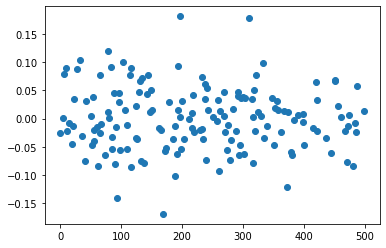

In [76]:
plt.plot(correctDataWithResiduals.residual, 'o')
# plot the scatter plot of the residual to detect curvilinearity or heteroskedasticity

(array([ 2.,  2., 15., 27., 44., 34., 18., 13.,  1.,  2.]),
 array([-0.16906406, -0.13402473, -0.0989854 , -0.06394607, -0.02890674,
         0.00613259,  0.04117191,  0.07621124,  0.11125057,  0.1462899 ,
         0.18132923]),
 <a list of 10 Patch objects>)

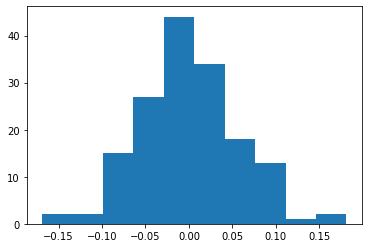

In [77]:
plt.hist(correctDataWithResiduals.residual)

In [78]:
correctDataWithResiduals[['is_happy_customer','distance_to_nearest_warehouse','delivery_charges','is_expedited_delivery']].corr()

,is_happy_customer,distance_to_nearest_warehouse,delivery_charges,is_expedited_delivery
is_happy_customer,1.000000,-0.159494,0.326515,-0.098613
distance_to_nearest_warehouse,-0.159494,1.000000,0.294231,0.017211
delivery_charges,0.326515,0.294231,1.000000,0.559437
is_expedited_delivery,-0.098613,0.017211,0.559437,1.000000


The scatter plot of the residuals does not show any curvilinearity or heteroskedasticity, and the residuals are very close to normal distribution in the histogram. Additionally, the ``is_expedited_delivery`` and three other variables are all very weakly or moderately correlated to another (independence). Therefore, we can assume a linear dependency between ``is_expedited_delivery`` and other three variables. In fact, when implementing the same procedure after filling out the missing variables in ``missing_data.csv``, the normal distribution of the residuals and well as randomness of residuals becomes even clearer. In addition, the ``is_expedited_delivery`` value in the correctDataWithResiduals and the rounded predicted values generated by the ResidualCalculator are identical. The imputed ``missing_data.csv`` also proved that the predicted target values are identical to the actual values in the original data frame. Therefore, I checked the ``is_expedited_delivery`` value by implementing this model. 

In [79]:
set(correctDataWithResiduals['is_expedited_delivery'] == round(correctDataWithResiduals['predicted_dependentVar']))
# 'predicted_dependentVar' calculated by the multiple linear regression model is identical to the real values 

{True}

In [80]:
orders = pd.concat([ResidualCalculator(seasonName, orders, 'is_expedited_delivery') \
     for seasonName in pd.unique(orders.season)])

# using multiple-regression model, calculate the predicted target value 'is_expedited_delivery' and the residual 
# between the real value and the predicted target value using ResidualCalculator
# concatenate all the data frames in the list correctDataWithResiduals

/Users/dahyekim/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/dahyekim/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/dahyekim/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

In [81]:
faultyExpeditedDeliveryIndex = list(orders.index[orders.is_expedited_delivery != round(orders['predicted_dependentVar'])])
# retrieve the index of rows whose predicted is_expedited_delivery differs from the original value 
semantic += faultyExpeditedDeliveryIndex
# add the row index above to semantic list 

In [82]:
orders.loc[faultyExpeditedDeliveryIndex,'is_expedited_delivery'] = \
1- orders.loc[faultyExpeditedDeliveryIndex,'is_expedited_delivery']
# reverse the binary number in is_expedited_delivery column (1 to 0, 0 to 1) if recognised as faulty

In [83]:
orders.is_happy_customer = orders.is_happy_customer.apply(lambda x: True if x == 1 else False)
orders.is_expedited_delivery = orders.is_expedited_delivery.apply(lambda x: True if x == 1 else False)
# change the binary numbers to True and False as it was in the original data frame

orders.drop(['predicted_dependentVar','residual'], axis = 1, inplace = True)
# drop the columns that are not in the original data frame 

In [84]:
print(len(semantic),len(set(semantic)))
# no rows have more than 2 semantic errors

212 212


In [85]:
orders.sort_index(inplace = True)
# sort the data based on the original index - maintaining the row order of the original data frame 
orders.to_csv('dirty_data_solution.csv', index = False)

# Part 2. Imputing Missing Values

Part 2 detects columns with missing values and imputes the missing ones based on the client's business rules. Based on the values returned from ``isnull().sum()`` function, following columns has null values: 

* ``nearest_warehouse``

* ``order_price``

* ``delivery_charges``

* ``order_total``

* ``distance_to_nearest_warehouse``

* ``is_happy_customer``

The imputation was implemented under the assumption that all the values in the csv file is correct.

In [86]:
missing = pd.read_csv('missing_data.csv')
# reading in the csv file with missing values 

In [87]:
missing.isnull().sum()
# checking the columns with NaNs 

order_id                          0
customer_id                       0
date                              0
nearest_warehouse                55
shopping_cart                     0
order_price                      15
delivery_charges                 40
customer_lat                      0
customer_long                     0
coupon_discount                   0
order_total                      15
season                            0
is_expedited_delivery             0
distance_to_nearest_warehouse    31
latest_customer_review            0
is_happy_customer                40
dtype: int64

## 1. Filling Missing Values in ``is_happy_customer`` column


The order of imputation was decided based on the independence of the columns with missing values. As an instance, the column ``is_happy_customer`` is indepedent of any columns listed above, but only related to the values in the ``latest_customer_review`` column. Therefore, I started the imputation process with this column first following the process below: 

1. Retrieve the index number of the rows with missing value in ``is_happy_customer`` column 
2. Loop through each index number and calculate the polarity score based on the matching ``latest_customer_review`` 
3. Based on the business rule, if the customer review is ``'None'``, the customer is regarded as a happy customer from the last order. 
4. For all other reviews, if the polarity score is less than 0.05, the customer is regarded as an unhappy customer. Therefore, the value to ``is_happy_customer`` column is ``False``. Otherwise the value is ``True``. 

In [88]:
missing.head()

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,coupon_discount,order_total,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer
0,ORD301034,ID0579980028,2019-04-27,Thompson,"[('Candle Inferno', 2), ('Universe Note', 2), ...",12080.0,64.08,-37.807924,144.942578,10,10936.08,Autumn,False,0.6599,"olivia universe s5 great phone, great condition",1.0
1,ORD426641,ID6167266647,2019-02-10,Nickolson,"[('Olivia x460', 1), ('Candle Inferno', 1), ('...",15505.0,76.44,-37.809552,144.964562,5,14806.19,Summer,False,1.0981,official product got the phone and it is all g...,1.0
2,ORD178169,ID0845657621,2019-09-04,NaN,"[('pearTV', 2), ('iStream', 2), ('Alcon 10', 1)]",21870.0,71.00,-37.817934,144.967651,0,21941.00,Spring,False,0.1826,the best budget version huaweii i’ve had the b...,1.0
3,ORD487277,ID2318307716,2019-08-13,Nickolson,"[('Alcon 10', 1), ('Lucent 330S', 2)]",11410.0,76.59,-37.810830,144.975836,15,9775.09,Winter,True,1.0260,"happy with the purchase, found it on sale coul...",1.0
4,ORD168321,ID0298045607,2019-02-26,Nickolson,"[('Alcon 10', 1), ('Toshika 750', 2), ('Lucent...",25130.0,91.85,-37.824183,144.963221,0,25221.85,Summer,True,0.8347,five stars everything worked like it said.,1.0


In [89]:
happy_missing_index = missing.index[missing.is_happy_customer.isnull()]
# retrieve the index number of rows where is_happy_customer value is missing 

In [90]:
for index in happy_missing_index: 
# looping through each index number in happy_missing_index 

    polarityScore = sid.polarity_scores(missing.loc[index,'latest_customer_review'])['compound']
    # calculate the polarity score based on the latest_customer_review 
    
    if missing.loc[index, 'latest_customer_review'] == 'None': 
        missing.loc[index,'is_happy_customer'] = 1
        # if the latest_customer_review is 'None', 'is_happy_customer' of the matching row is True
        
    elif polarityScore<0.05: 
        missing.loc[index,'is_happy_customer'] = 0
        # 'is_happy_customer' value where the polarity score of latest_customer_review is less than 5 should be False
    else: 
        missing.loc[index,'is_happy_customer'] = 1
        # Otherwise, the missing value is True 

## 2. Filling Missing Values in ``order_price`` and ``order_total`` columns

When correcting the dirty data, I managed to calculate the unit price of unique product from the client. The matching product name and the price is stored in a dictionary called ``productPrice``. To impute the missing value in ``order_price`` column, I used the same method that I used when detecting errors in ``order_price`` column in ``dirty_data.csv``. 

In [91]:
set(missing.index[missing.order_price.isnull()]) == set(missing.index[missing.order_total.isnull()])
# the rows whose order_price and order_total are missing are the same rows 

True

Since the rows with missing values in ``order_price`` column is also missing values in ``order_total`` column, I imputed both columns together. According to the business rule of the company, the values in ``total_price`` column is calculated as follow:

$$
\text{total price} = \text{order price} \times \frac{(100-\text{discount rate})}{100} + \text{delivery charge}
$$

Since ``order_total`` is dependent on ``order_price``, I first imputed the ``order_price`` column.

In [92]:
missing['shopping_cart'] = \
missing['shopping_cart'].apply(lambda x: list(zip(re.findall(r"\(\'(.+?)\',",x), [int(qty) for qty in re.findall(r"\, ([0-9]{1})\)",x)])))
# convert the string values in the shopping_cart column into a list of tuples

In [93]:
price_missing = missing.index[missing.order_price.isnull()]
# the index of rows whose order_price is missing 
# These are also the index of rows whose order_total is missing 

In [94]:
missing.loc[price_missing, 'order_price'] = missing.loc[price_missing,'shopping_cart'].apply(lambda x:\
                                                                                            sum({productPrice[tup[0]]*int(tup[1]) for tup in x}))
# calculate the order_price of the missing values based on the individual product price in productPrice dictionary 

missing.loc[price_missing, 'order_total'] = missing.loc[price_missing, 'order_price']*(100-missing.loc[price_missing, 'coupon_discount'])*0.01+\
missing.loc[price_missing, 'delivery_charges']
# fill in the order_total values in the same rows after calculating the missing order_price values 

## 3. Filling Missing ``delivery_charges``

Based on the business rule, the ``delivery_charges`` column is the difference between the ``total_price`` and the ``order_price`` after the applied coupon discount: 

$$
\text{delivery charge} = \text{total price}-\text{order price} \times \frac{(100-\text{discount rate})}{100}
$$

To validate this formula, I created a seperate data frame called ``delivery_complete`` by retrieving all the rows whose ``delivery_charges`` values are completed. Then I applied the formula above and calculated the delivery charges with the correct ``order_total`` and ``order_price`` columns and stored the values into a new column called ``delivery_inverse``. If the values in ``delivery_inverse`` column are identical to those in ``delivery_charges``, then we can directly apply the formula above to fill in the empty values in ``delivery_charges`` column.

In [95]:
delivery_complete = missing[~missing.delivery_charges.isnull()]
# '~' means 'not' in pandas, similar to '!' in R
# a seperate data frame whose 'delivery_charges' is not null 

delivery_complete['delivery_inverse'] = round(delivery_complete.order_total -\
delivery_complete.order_price*(100-delivery_complete.coupon_discount)*0.01,2)
# apply the formula above to all the rows with no missing values 

/Users/dahyekim/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [96]:
set(delivery_complete['delivery_charges']==delivery_complete['delivery_inverse'])
# two columns are identical and thus we can apply the formula to the empty rows in ``delivery_charges`` column.

{True}

In [97]:
delivery_missing_index = missing.index[missing.delivery_charges.isnull()]
# retrieve the index of rows whose delivery_charges is missing 

missing.loc[delivery_missing_index, 'delivery_charges'] = \
round(missing.loc[delivery_missing_index, 'order_total'] -\
missing.loc[delivery_missing_index, 'order_price']*\
      (100-missing.loc[delivery_missing_index, 'coupon_discount'])*0.01,2)
# apply the formula above with two-decimal places 

## 4. Filling Missing ``distance_to_nearest_warehouse`` & ``nearest_warehouse``

After checking the index of rows whose ``distance_to_nearest_warehouse`` and ``nearest_warehouse`` are missing, I realised that all the rows with missing ``nearest_warehouse`` values are, in fact, also missing ``distance_to_nearest_warehouse`` values. To impute ``nearest_warehouse``, I need to obtain the missing ``distance_to_nearest_warehouse`` first, and therefore, I resolve the missing values of these two columns together by using the following steps: 

1. Create a seperate data frame ``distance`` which contains the ``customer_lat`` and ``customer_long`` of those rows whose ``distance_to_nearest_warehouse`` and ``nearest_warehouse`` values are missing
2. In the new data frame, create new columns named after each warehouse, whose values are the distance between the customer and the matching warehouse. 
3. Calculate the distance between each warehouse and the customer location using ``haversine()`` function 
4. Create a new column ``recalc_nearest_warehouse`` by selecting the warehouse with the shortest distance to the customer in each row 
5. Create a new column ``recalc_distance_to_nearest_warehouse`` by inserting the distance between the customer and the nearest warehouse in ``recalc_nearest_warehouse`` column
6. Impute the missing values in ``distance_to_nearest_warehouse`` and ``nearest_warehouse`` by using ``.loc[]`` function

In [98]:
set(missing.index[missing.distance_to_nearest_warehouse.isnull()].isin(missing.index[missing.nearest_warehouse.isnull()]))
# the rows whose distance_to_nearest_warehouse are missing are also missing data in nearest_warehouse column

{True}

In [98]:
distance = missing[['customer_lat','customer_long']][missing.nearest_warehouse.isnull()|\
                                                               missing.distance_to_nearest_warehouse.isnull()]
# distance is a new data frame containing the customer_lat and customer_long of those rows whose 
# nearest_warehouse and distance_to_nearest_warehouse are missing 

In [99]:
distance

,customer_lat,customer_long
2,-37.817934,144.967651
8,-37.819790,144.942588
24,-37.814294,145.006235
29,-37.809549,144.963874
51,-37.811742,144.953404
53,-37.815102,144.945021
56,-37.805267,144.942483
64,-37.811156,144.964081
65,-37.812901,144.942889
68,-37.814306,144.963354


In [100]:
for warehouseName in warehouseLocation.keys(): 
    distance[warehouseName] = np.nan
    # create column named after each warehouse
    for i in distance.index: 
        customer_location = (distance.loc[i,'customer_lat'],distance.loc[i,'customer_long'])
        # create (latitude, longitude) tuple of each customer location 
        distance.loc[i, warehouseName] = round(haversine(customer_location, warehouseLocation[warehouseName]),4)
        # calculate haversine distance between each warehouse and the customer location, rounded by 4 decimal places


In [101]:
distance['recalc_nearest_warehouse'] = distance[set(warehouseLocation.keys())].idxmin(axis = 1)
# 'recalc_nearest_warehouse' is the name of the warehouse whose distance is the shortest from the customer
distance['recalc_distance_to_nearest_warehouse'] = \
distance[set(warehouseLocation.keys())].min(axis = 1)
# 'recalc_distance_to_nearest_warehouse' is the distance between the nearest_warehouse and the customer 

In [102]:
missing.loc[set(missing.index[missing.nearest_warehouse.isnull()]),'nearest_warehouse'] = \
distance.loc[set(missing.index[missing.nearest_warehouse.isnull()]),'recalc_nearest_warehouse']
# imputing the 'nearest_warehouse' missing values calculated in the distance dataframe 

missing.loc[set(missing.index[missing.distance_to_nearest_warehouse.isnull()]),'distance_to_nearest_warehouse'] = \
distance.loc[set(missing.index[missing.distance_to_nearest_warehouse.isnull()]),'recalc_distance_to_nearest_warehouse']
# imputing the 'distance_to_nearest_warehouse' missing values calculated in the distance dataframe 

In [103]:
missing.isnull().sum()
# no more missing values detected 

order_id                         0
customer_id                      0
date                             0
nearest_warehouse                0
shopping_cart                    0
order_price                      0
delivery_charges                 0
customer_lat                     0
customer_long                    0
coupon_discount                  0
order_total                      0
season                           0
is_expedited_delivery            0
distance_to_nearest_warehouse    0
latest_customer_review           0
is_happy_customer                0
dtype: int64

In [104]:
missing.sort_index(inplace = True)
missing.to_csv('missing_data_solution.csv', index = False)
# exported the data frame after imputing all the missing values

# Part 3. Removing Outliers

Before removing the outliers, we need to identify whether the ``delivery_charges`` attribute is independent from other attributes. If so, we can define the outliers in this attribute as univariate outliers and remove them straight away. Otherwise, we should build a model using other related attributes according to the business rule, and remove the multivariate outliers based on the distribution of the residuals. Residuals refers to the 'noise' between the values derived by the model we built and the actual values. The distribution of the residuals conveys the distribution of the attribute that we are working with in accordance to its related attributes - if the residual is exceptionally higher or lower than the norms, the data point is significantly deviating from the model and thus the relationship between the attributes. Therefore, the univariate outliers of the residual values direct us to the multivariate outliers that we are looking for. 

According to the business rule of the client, ``delivery_charges`` attribute is calculated using a linear model. The model linearly depends on ``distance_to_nearest_warehouse``, ``is_happy_customer``, and ``is_expedited_delivery`` attributes, and the model differs based on each season. Since we are given that the ``delivery_charges`` is linearly dependent on three other attributes, we should build multi-linear regression model of ``delivery_charges``. Since the model differs in each season, we should build four different multi-linear regression model.

Based on the linear regression model, we calculate the 'predicted delivery charges' and obtain the residual of each data point by subtracting it to original ``delivery_charges``. After retrieving the residuals, we observe the distribution of residuals and obtain the outliers of the residual distributions. These outliers are the multivariate outliers of ``delivery_charges`` that we are looking for. 

In [105]:
outlier = pd.read_csv('outlier_data.csv')

In [106]:
outlier.is_happy_customer = outlier.is_happy_customer.apply(lambda x: 1 if x == True else 0)
outlier.is_expedited_delivery = outlier.is_expedited_delivery.apply(lambda x: 1 if x == True else 0)
# is_happy_customer and is_expedited_delivery are booleans. 
# to obtain the linear regression model, we convert the booleans to matching integers 
# 1 if x == True else 0: if the value is True, change the cell value to 1. Otherwise, change the value to 0. 

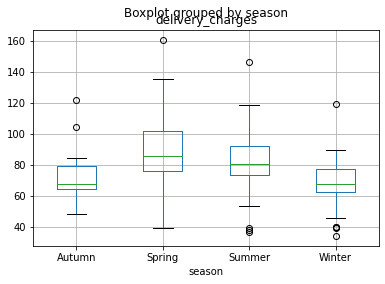

In [107]:
deliveryCharges_bp = outlier.boxplot(column = 'delivery_charges', by = 'season')
# Outliers above and below the upper and lower whisker are observed after grouping by season

In [108]:
df_withResidual =[ResidualCalculator(seasonName, outlier, 'delivery_charges') for seasonName in pd.unique(outlier.season)]
# The outlier data frame is seperated into multiple data frames based on the season 
# ResidualCalculator builds a linear regression model based on the related variables and returns the data frames 
# after inserting the predicted values and residuals 

/Users/dahyekim/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/dahyekim/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/dahyekim/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

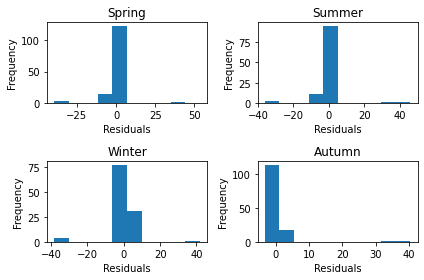

In [109]:
f,a = plt.subplots(2,2)
# divising plan for the histogram 
a = a.ravel()
n=0
# index of df_withResidual

for idx,ax in enumerate(a):
# for each subsection of the subplots 
    season = pd.unique(outlier['season'])
    # individual season name 
    ax.hist(df_withResidual[n]['residual'][outlier.season ==season[n]])
    # plot the histogram of the residual from each data frame in df_withResidual list 
    ax.set_xlabel('Residuals')
    ax.set_ylabel('Frequency')
    # labelling x-axis and y-axis 
    
    ax.set_title(season[n])
    # set the main title of the histogram to the season name 
    
    n+=1
    
plt.tight_layout()

The outliers from the ``residual`` values are univariate outliers. As portraited above with the histogram, the distribution of the residuals are not completely normal - especially that of the season Autumn is highly skewed to the right. The skewness of the distribution shifts the centre to the direction of the skewness, and thus we cannot use $3\sigma$ rules. To detect the outliers in ``residual`` columns, I adopted the **Quartile-based Detection and Boxplots method**. 

In [110]:
for i in df_withResidual: 
# loop through each data frame in df_withResidual list 

    stats = dict(i['residual'].describe())
    # convert the statistics summary returned from .describe() function to a dictionary
    iqr = stats['75%']-stats['25%']
    # IQR is the difference between the 3rd and 1st quartile of the distribution 
    
    upperWhisker = stats['75%']+1.5*iqr
    # the data points located above the upper whisker are upper outliers 
    lowerWhisker = stats['25%']-1.5*iqr
    # the data points located below the lower whisker are lower outliers 
    
    i.drop(i.index[(i.residual<lowerWhisker)|(i.residual>upperWhisker)], inplace = True)
    # drop all the data points located either under the lower whisker or above the upper whisker

/Users/dahyekim/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


To visualise the changes to the distribution after removing the outliers, I plot the distribution of ``residual`` and ``delivery_charges`` from each season.

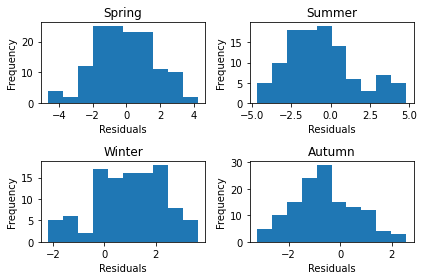

In [111]:
f,a = plt.subplots(2,2)
a = a.ravel()
n=0
for idx,ax in enumerate(a):
    # individual season name 
    ax.hist(df_withResidual[n]['residual'][outlier.season ==season[n]])
    # plot the histogram of the residual from each data frame in df_withResidual list 
    ax.set_xlabel('Residuals')
    ax.set_ylabel('Frequency')
    ax.set_title(season[n])
    n+=1
plt.tight_layout()

After removing the outliers of the residuals, the distribution of the residuals look much more centralised and clear in the spread of the distribution. No significant outliers are observed after removing the outliers in the first stage. 

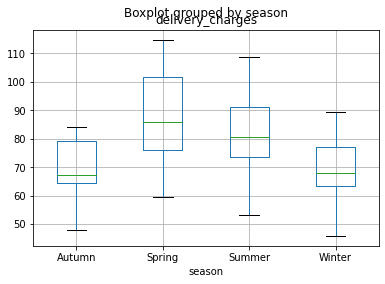

In [112]:
outlier = pd.concat(df_withResidual)
# concatenate all the data frames in df_withResidual list 
deliveryCharges_bp = outlier.boxplot(column = 'delivery_charges', by = 'season')

In contrast to the boxplot at the start of Part 3, the outliers of ``delivery_charges`` are now removed in each season. 

In [113]:
outlier.drop(['residual','predicted_dependentVar'], axis = 1, inplace = True)
# drop the columns that are not in the original data frame 

outlier.is_happy_customer = outlier.is_happy_customer.apply(lambda x: True if x == 1 else False)
outlier.is_expedited_delivery = outlier.is_expedited_delivery.apply(lambda x: True if x == 1 else False)
# Undo the binary conversion to the original Boolean values 

outlier.sort_index(inplace = True)
outlier.to_csv('outlier_data_solution.csv',index = False)

# Conclusion

The program cleansed three datasets with three different anomalies - syntatical anomalies, semantic anomalies, and coverage anomalies.  Additionally, it also removed outliers in specific column. The anomalies correction and outlier detection were all based on the business rules of the client. The program majorly utilised ``pandas`` library to manipulate data frames and corrected syntatical anomalies. For semantic anomalies, whose anomalies are dependent to other attributes, the program not only used ``pandas`` and ``numpy`` for calculating correct values, but also used ``sklearn`` to build a linear regression model to predict the correct value in certain columns. The same approach was applied when imputing missing data. Finally, the outlier detection was implemented using the multiple linear regression and the detected outliers were removed based on the Quartile-based Detection and Boxplots method.

## Bibliography

Get minimum values in rows or columns with their index position in Pandas-Dataframe. (2020, July 3). GeeksforGeeks. https://www.geeksforgeeks.org/get-minimum-values-in-rows-or-columns-with-their-index-position-in-pandas-dataframe/

Haversine. (2020, September 4). PyPI. https://pypi.org/project/haversine/

itertools — Functions creating iterators for efficient looping. (2012). Python v3.1.5 Documentation. https://docs.python.org/3.1/library/itertools.html?highlight=combinations

pandas boxplots as subplots with individual y-axis. (2018, April 6). Stack Overflow. https://stackoverflow.com/questions/49690316/pandas-boxplots-as-subplots-with-individual-y-axis

Python | List of tuples to dictionary conversion. (2019, May 1). GeeksforGeeks. https://www.geeksforgeeks.org/python-list-of-tuples-to-dictionary-conversion/

Swapping 1 with 0 and 0 with 1 in a Pythonic way. (2009, November 22). Stack Overflow. https://stackoverflow.com/questions/1779286/swapping-1-with-0-and-0-with-1-in-a-pythonic-way